## Introduction

The purpose of this notebook is to serve as a simple run of functional linear regression (FLR) on the Tecator data set. In particular, we use B-spline basis function expansions for both the functional inputs and the coefficient function, along with a roughness penalty. There will be a few main parts to this analysis:

1. Functional linear regression hyperparameter choice comparisons.
2. Functional linear regression using two nested grid searches: one to determine the optimal smoothing parameters and one to evaluate fold-wise $R^{2}$. We compare against OLS and ridge regression.

We offload most of the computation to `scripts/03_flr.py` and `src/fda_models.py` and only pull in plots and results in this notebook.

## Imports

In [1]:
from IPython.display import Image
import os
import pandas as pd
from pathlib import Path
import pickle

## Run the script `scripts/03_flr.py`

This script runs some FLR models and saves results for a quick analysis. Expect this script to run for a few minutes.

In [2]:
# Define the data directory to save to.
project_root = Path.cwd().resolve().parent
output_directory = project_root / "artifacts" / "original_data" / "03_flr"

# Define the data directory to read from.
data_location_directory = project_root / "data" / "original"

%run ../scripts/03_flr.py --out-dir "{output_directory}" --data-location-directory "{data_location_directory}"

162/1620 runs (10%) | elapsed 5.9s
324/1620 runs (20%) | elapsed 10.9s
486/1620 runs (30%) | elapsed 16.7s
648/1620 runs (40%) | elapsed 24.1s
810/1620 runs (50%) | elapsed 31.6s
972/1620 runs (60%) | elapsed 41.2s
1134/1620 runs (70%) | elapsed 48.9s
1296/1620 runs (80%) | elapsed 57.4s
1458/1620 runs (90%) | elapsed 69.4s
1620/1620 runs (100%) | elapsed 82.4s
Done with analysis plot generation! Proceding to repeated CV.


## Analyze results

Throughout this section, we vary values for $K_{X}$, $K_{\beta}$, and $\lambda$, which are the number of basis functions for the functional inputs, number of basis functions for the coefficient function, and roughness penalty in the least squares problem. We always examine predictive $R^{2}$ in leave-one-out cross-validation.

### $(K_{X}, K_{\beta}, \lambda)$-sweep

Let's do a huge sweep over these three parameters to see what happens. We use:
- $K_{X} \in \{5, 10, 15, \dots, 45\}$
- $K_{\beta} \in \{5, 10, 15, \dots, 45\}$
- $\log_{10}(\lambda) \in \{-15, -14, \dots, 4\}$

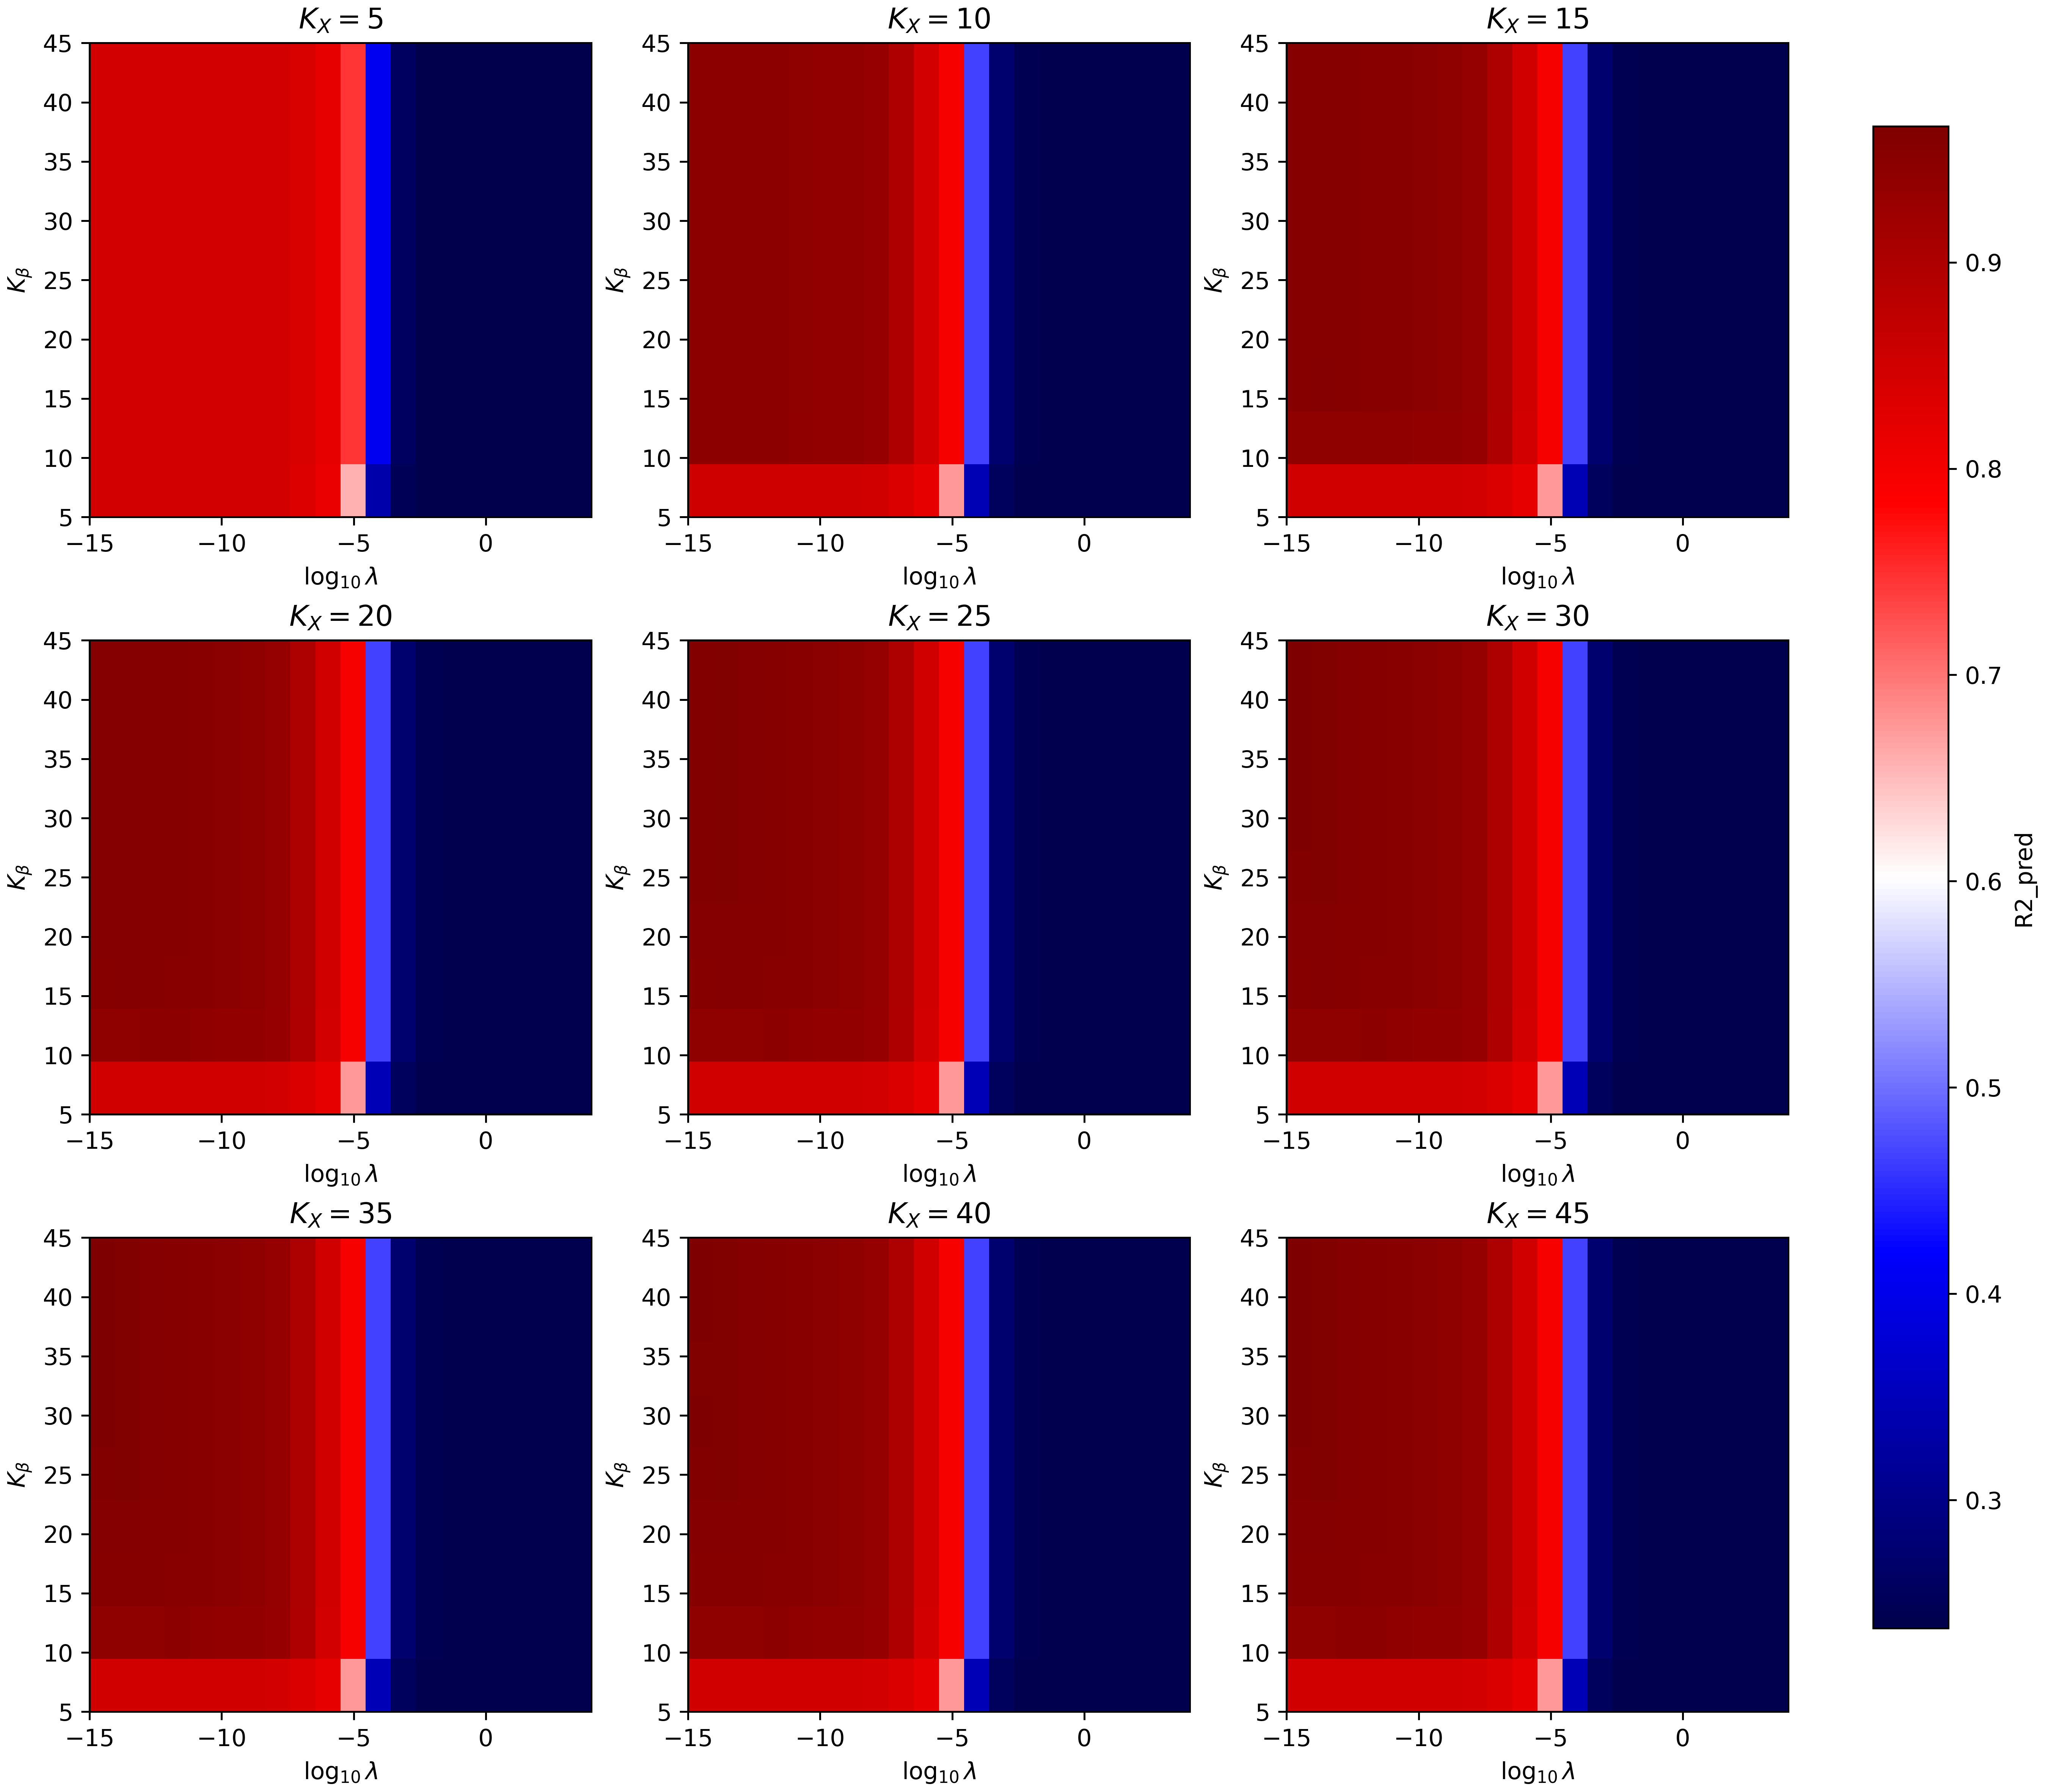

In [3]:
Image(filename="../artifacts/original_data/03_flr/plots/R2_heatmaps.png", width=800)

Predictive $R^{2}$ doesn't seem to change much across different values of $K_{X}$ (i.e. different plots) once $K_{X} \geq 10$!

### For fixed $K_{X}$, examine how $\lambda$ affects $R_{pred}^{2}$ per $K_{\beta}$

We present the above data in a different form. Again, each plot is a different value for $K_{X}$. However, now we plot a curve for each $K_{\beta}$ value, where the independent variable is $\lambda$.

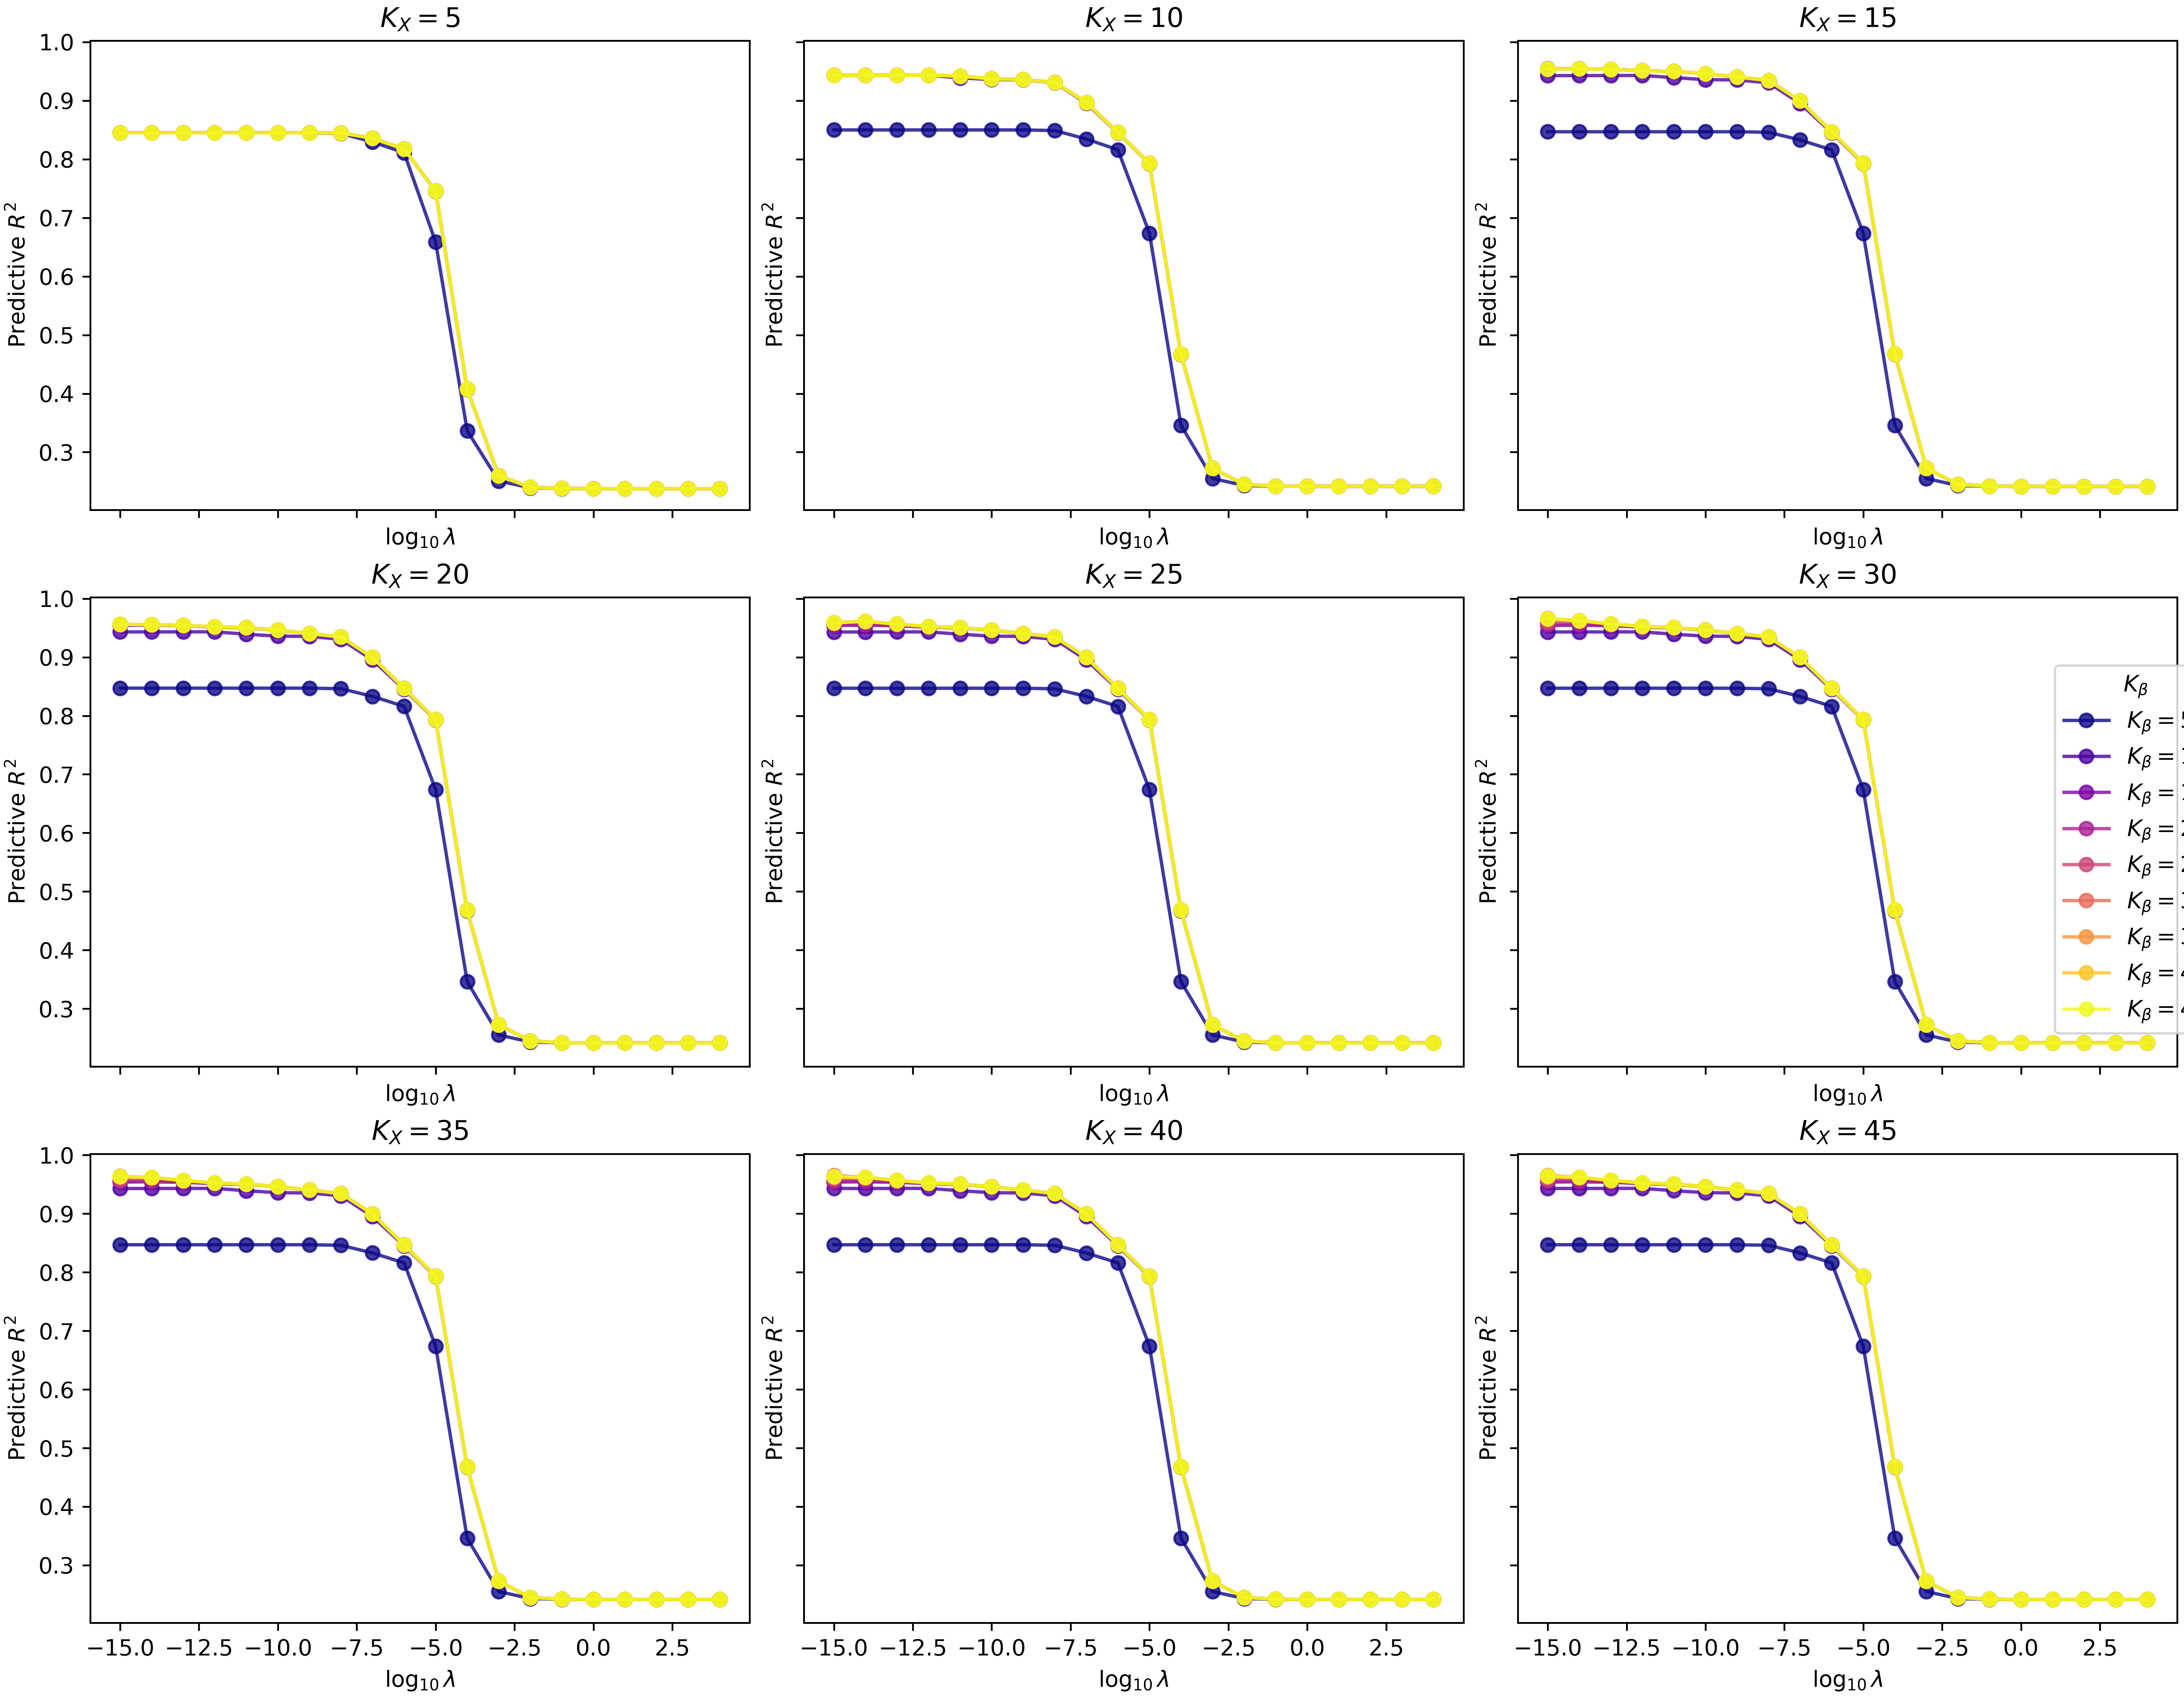

In [4]:
Image(filename="../artifacts/original_data/03_flr/plots/R2_vs_lambda_per_K.png", width=800)

This plot shows that, as long as $K_{\beta} \geq 5$ (i.e. we're not looking at the most blue curve), for a given $K_{X}$ (plot) the only parameter that matters is $\lambda$ (the independent variable). In every case, there is a sharp decrease in predictive $R^{2}$ once $\lambda$ grows past about $10^{-8}$.

### For each $(K_{X}, K_{\beta})$-pair, if we optimize $\lambda$ correctly, what is the maximum $R_{pred}^{2}$?

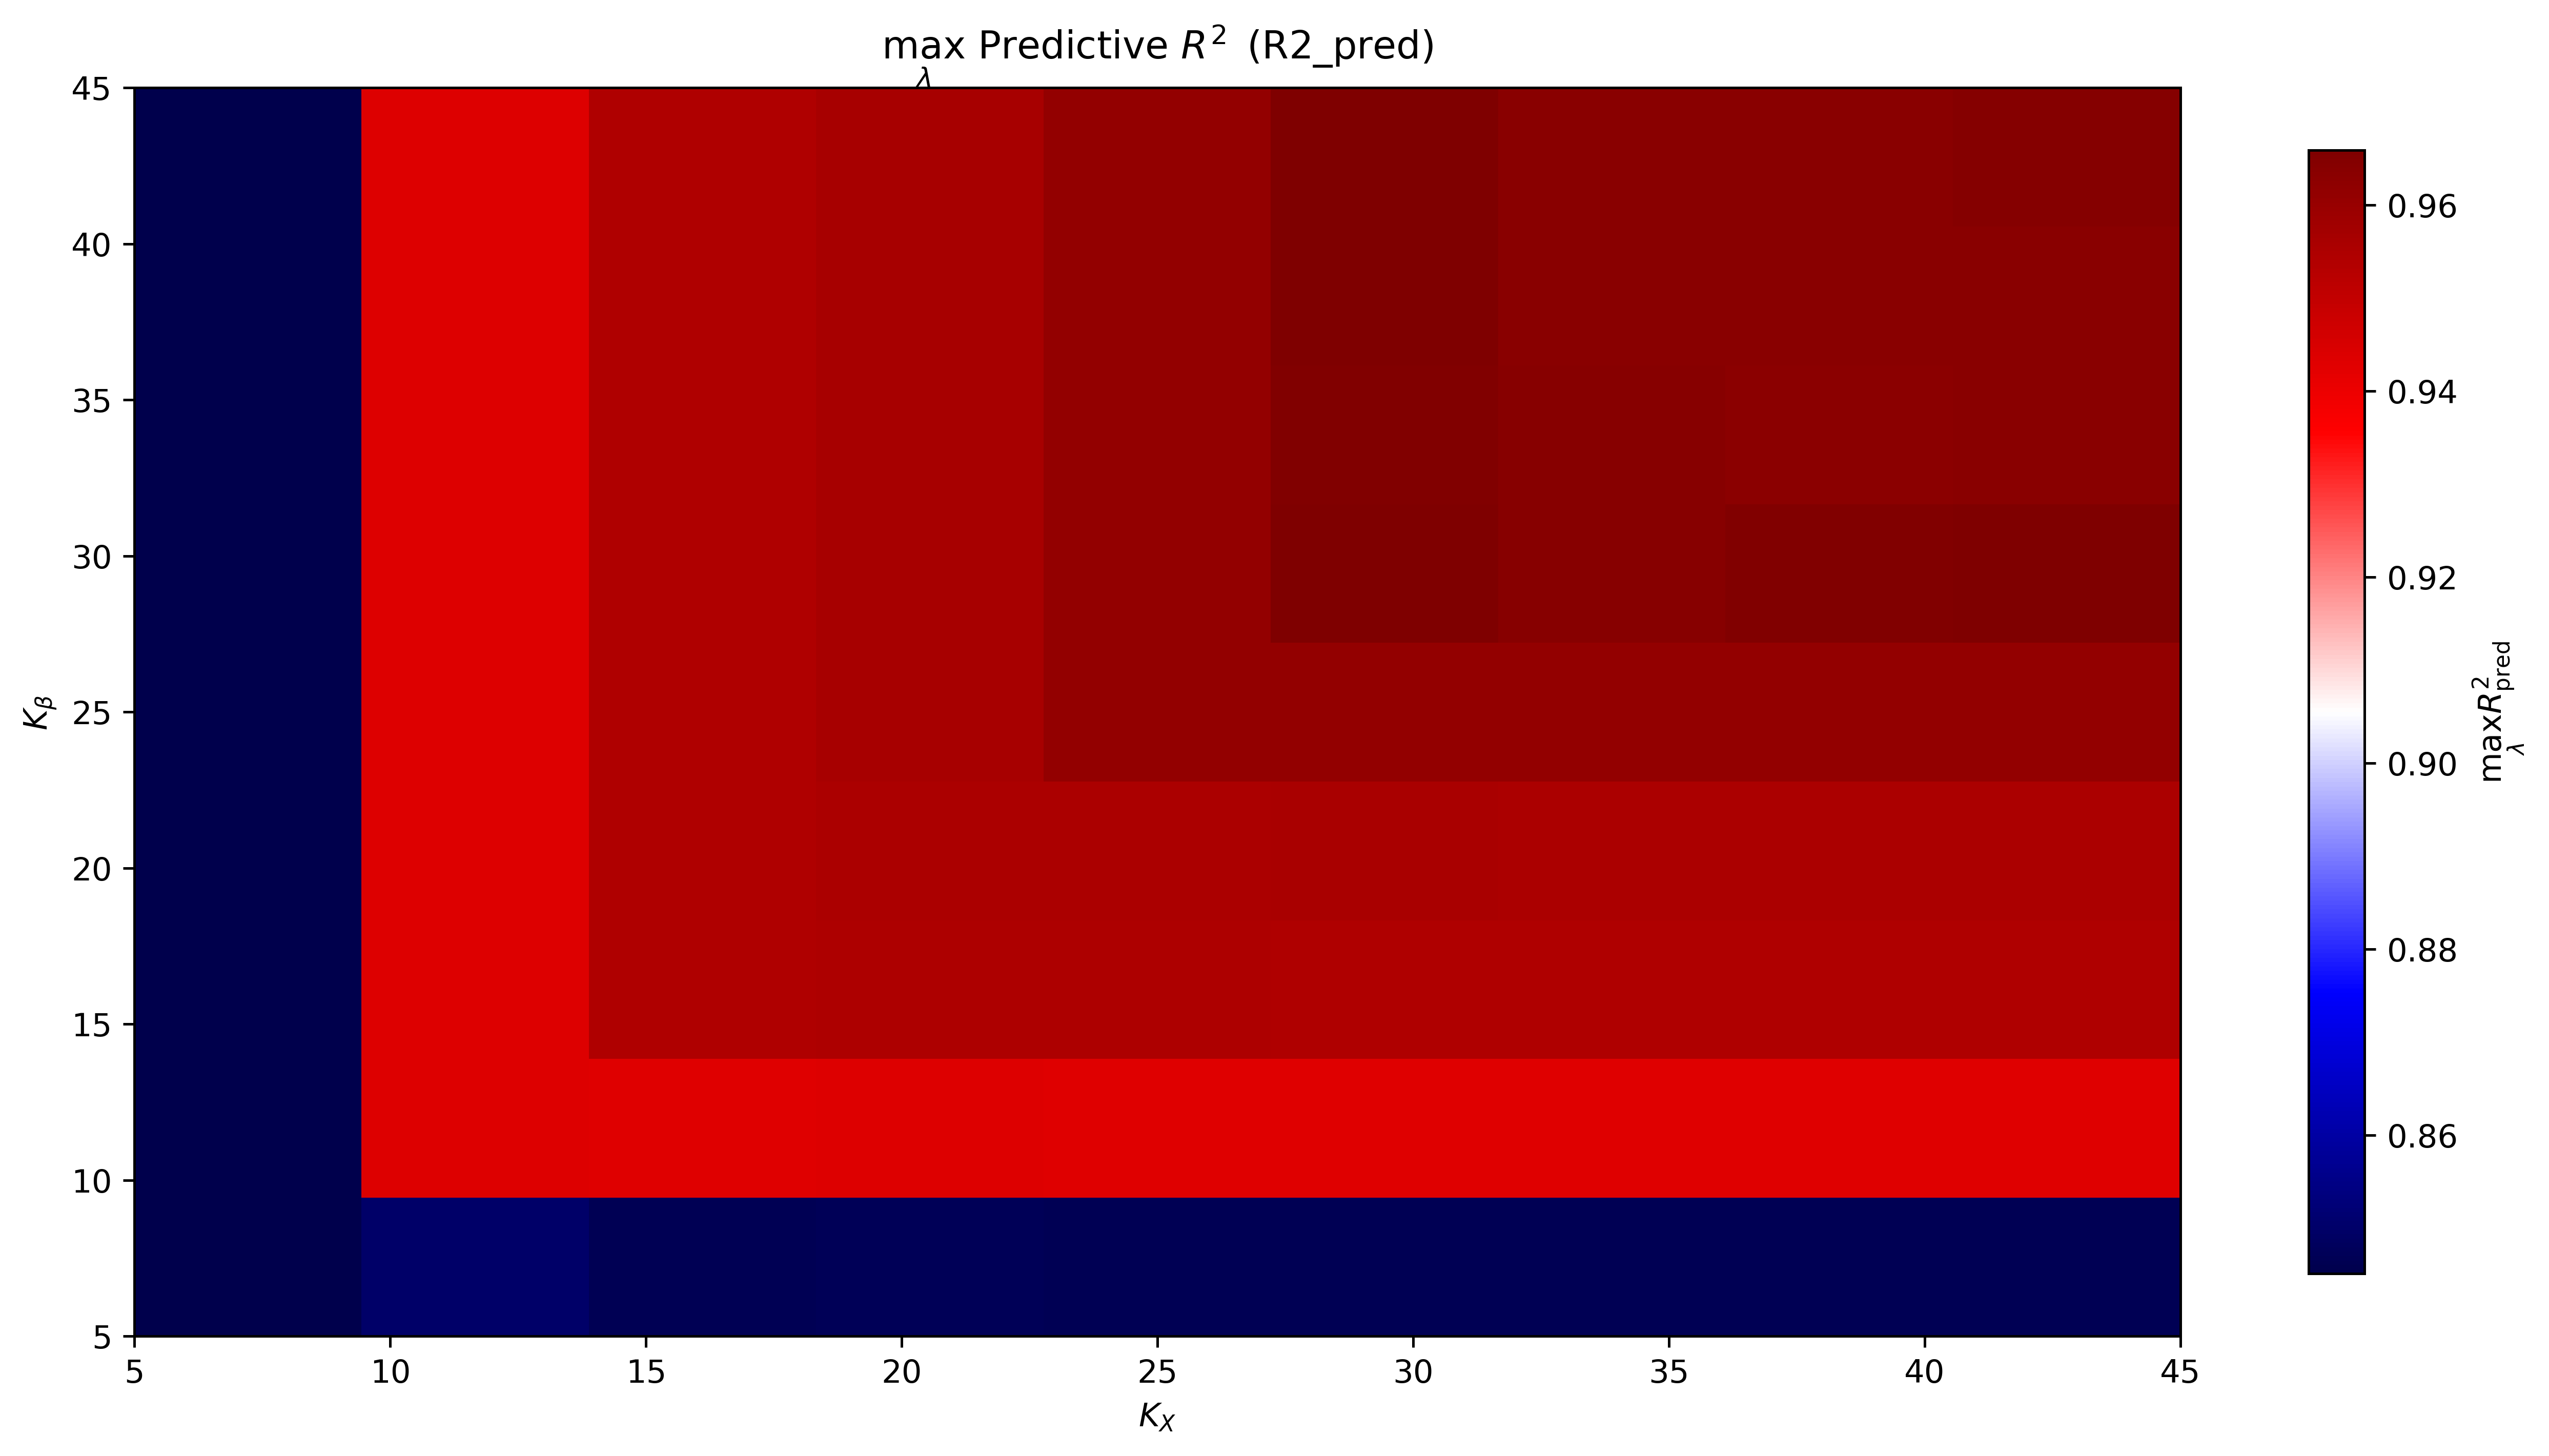

In [5]:
Image(filename="../artifacts/original_data/03_flr/plots/best_R2.png", width=800)

This plot shows that, given we choose $\lambda$ correctly, our best choices for $K_{X}$ and $K_{\beta}$ appear to be at least 30, with 30 basis functions for the functional inputs leading to great accuracy. Which hyperparameters produce the best predictive $R^{2}$ overall?

In [6]:
overall_predictive_df = pd.read_csv("../artifacts/original_data/03_flr/analysis_results/hyperparameter_sweep.csv")

overall_predictive_df.loc[overall_predictive_df["R2_pred"] == overall_predictive_df["R2_pred"].max()]

,K_X,K_beta,lam,log10_lam,R2_pred,CV_score,df,R2,time_sec
1000,30,30,1.000000e-15,-15.0,0.965883,1185.082043,24.252897,0.979084,0.000342


We can see that the best results are when:
- $K_{X} = 30$.
- $K_{\beta} = 30$.
- $\lambda = 10^{-15}$.

In this case, predictive $R^{2}$ is 0.965, while $R^{2}$ on the whole data set is given by 0.979. Now, there are many hyperparameter choices that give close to this value.

### Predictive $R^{2}$ vs. degrees of freedom

As our final plots, we show a relationship that ChatGPT is incredibly interested in. Instead of worrying about three parameters, we only focus on the degrees of freedom of the model. This can be found using the trace of the hat matrix, and lower means less flexbility in the model. In this case, it means a smoother fit, as $\lambda$ increasing implies hat matrix eigenvalues decreasing.

First, we plot all the values of $R_{pred}^{2}$ vs. $df$, colored by $K_{beta}$.

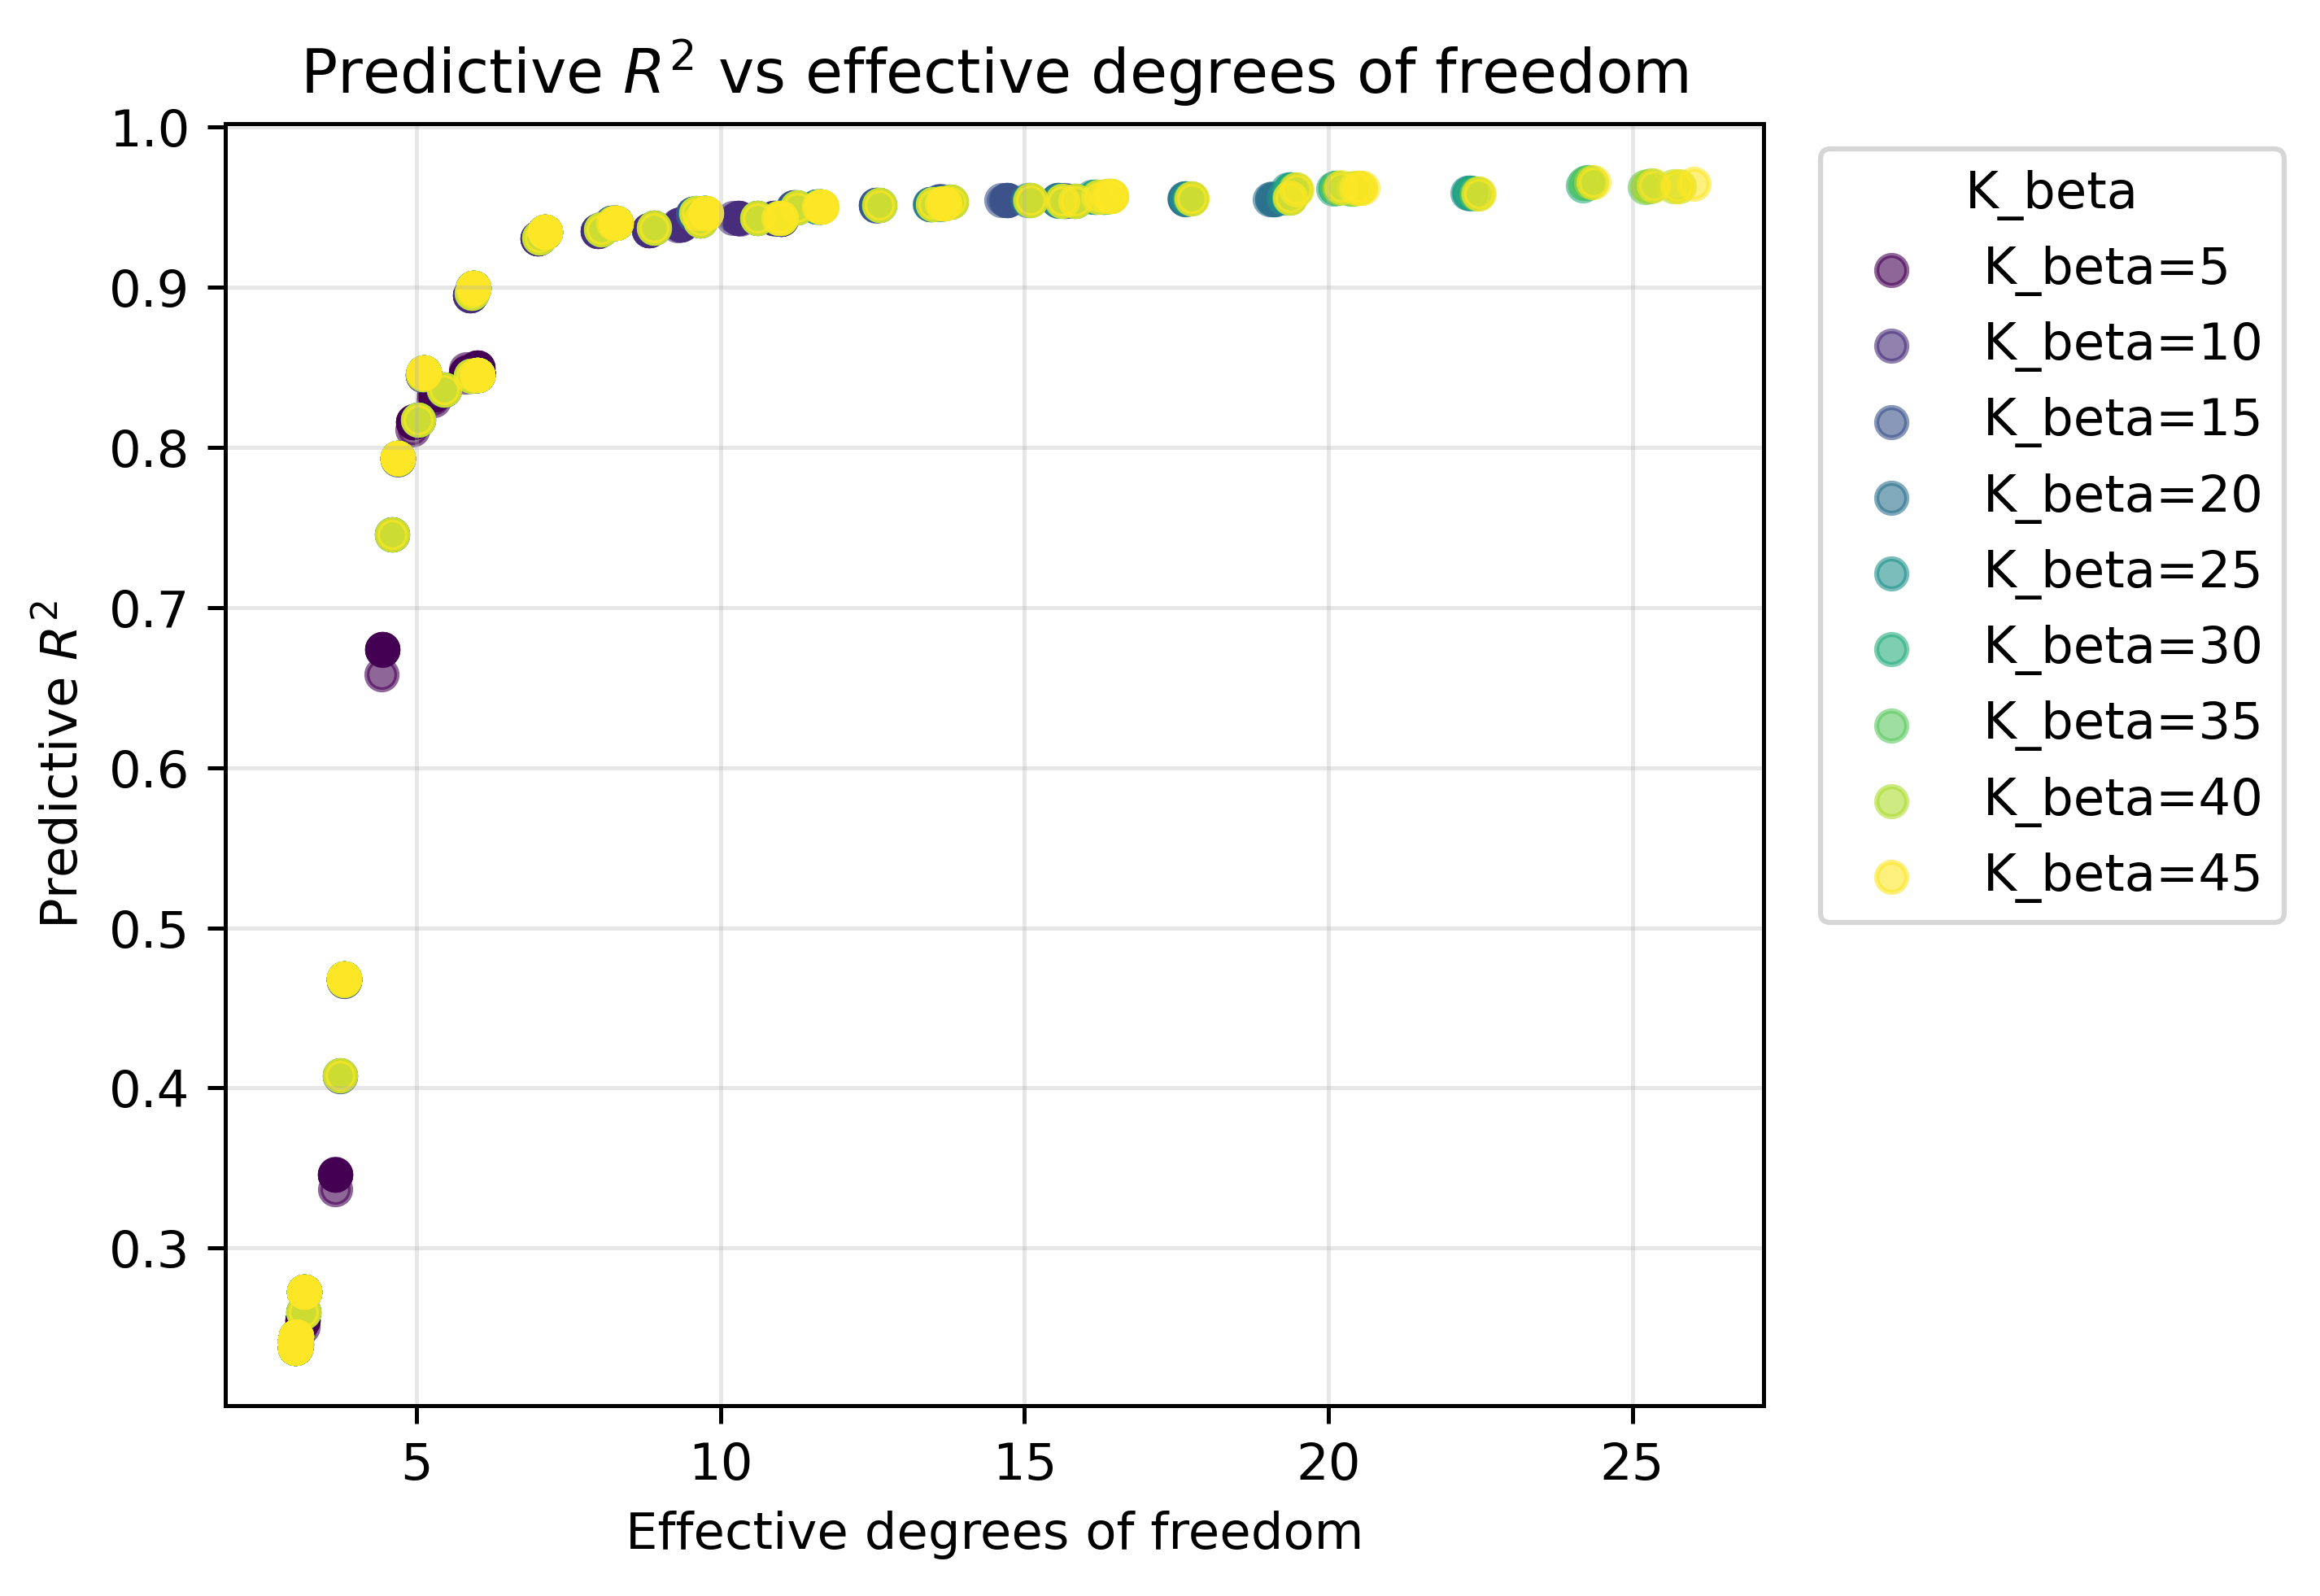

In [7]:
Image(filename="../artifacts/original_data/03_flr/plots/R2_vs_df.png", width=600)

Now, we form 15 bins according to $df$ and plot means and standard deviations.

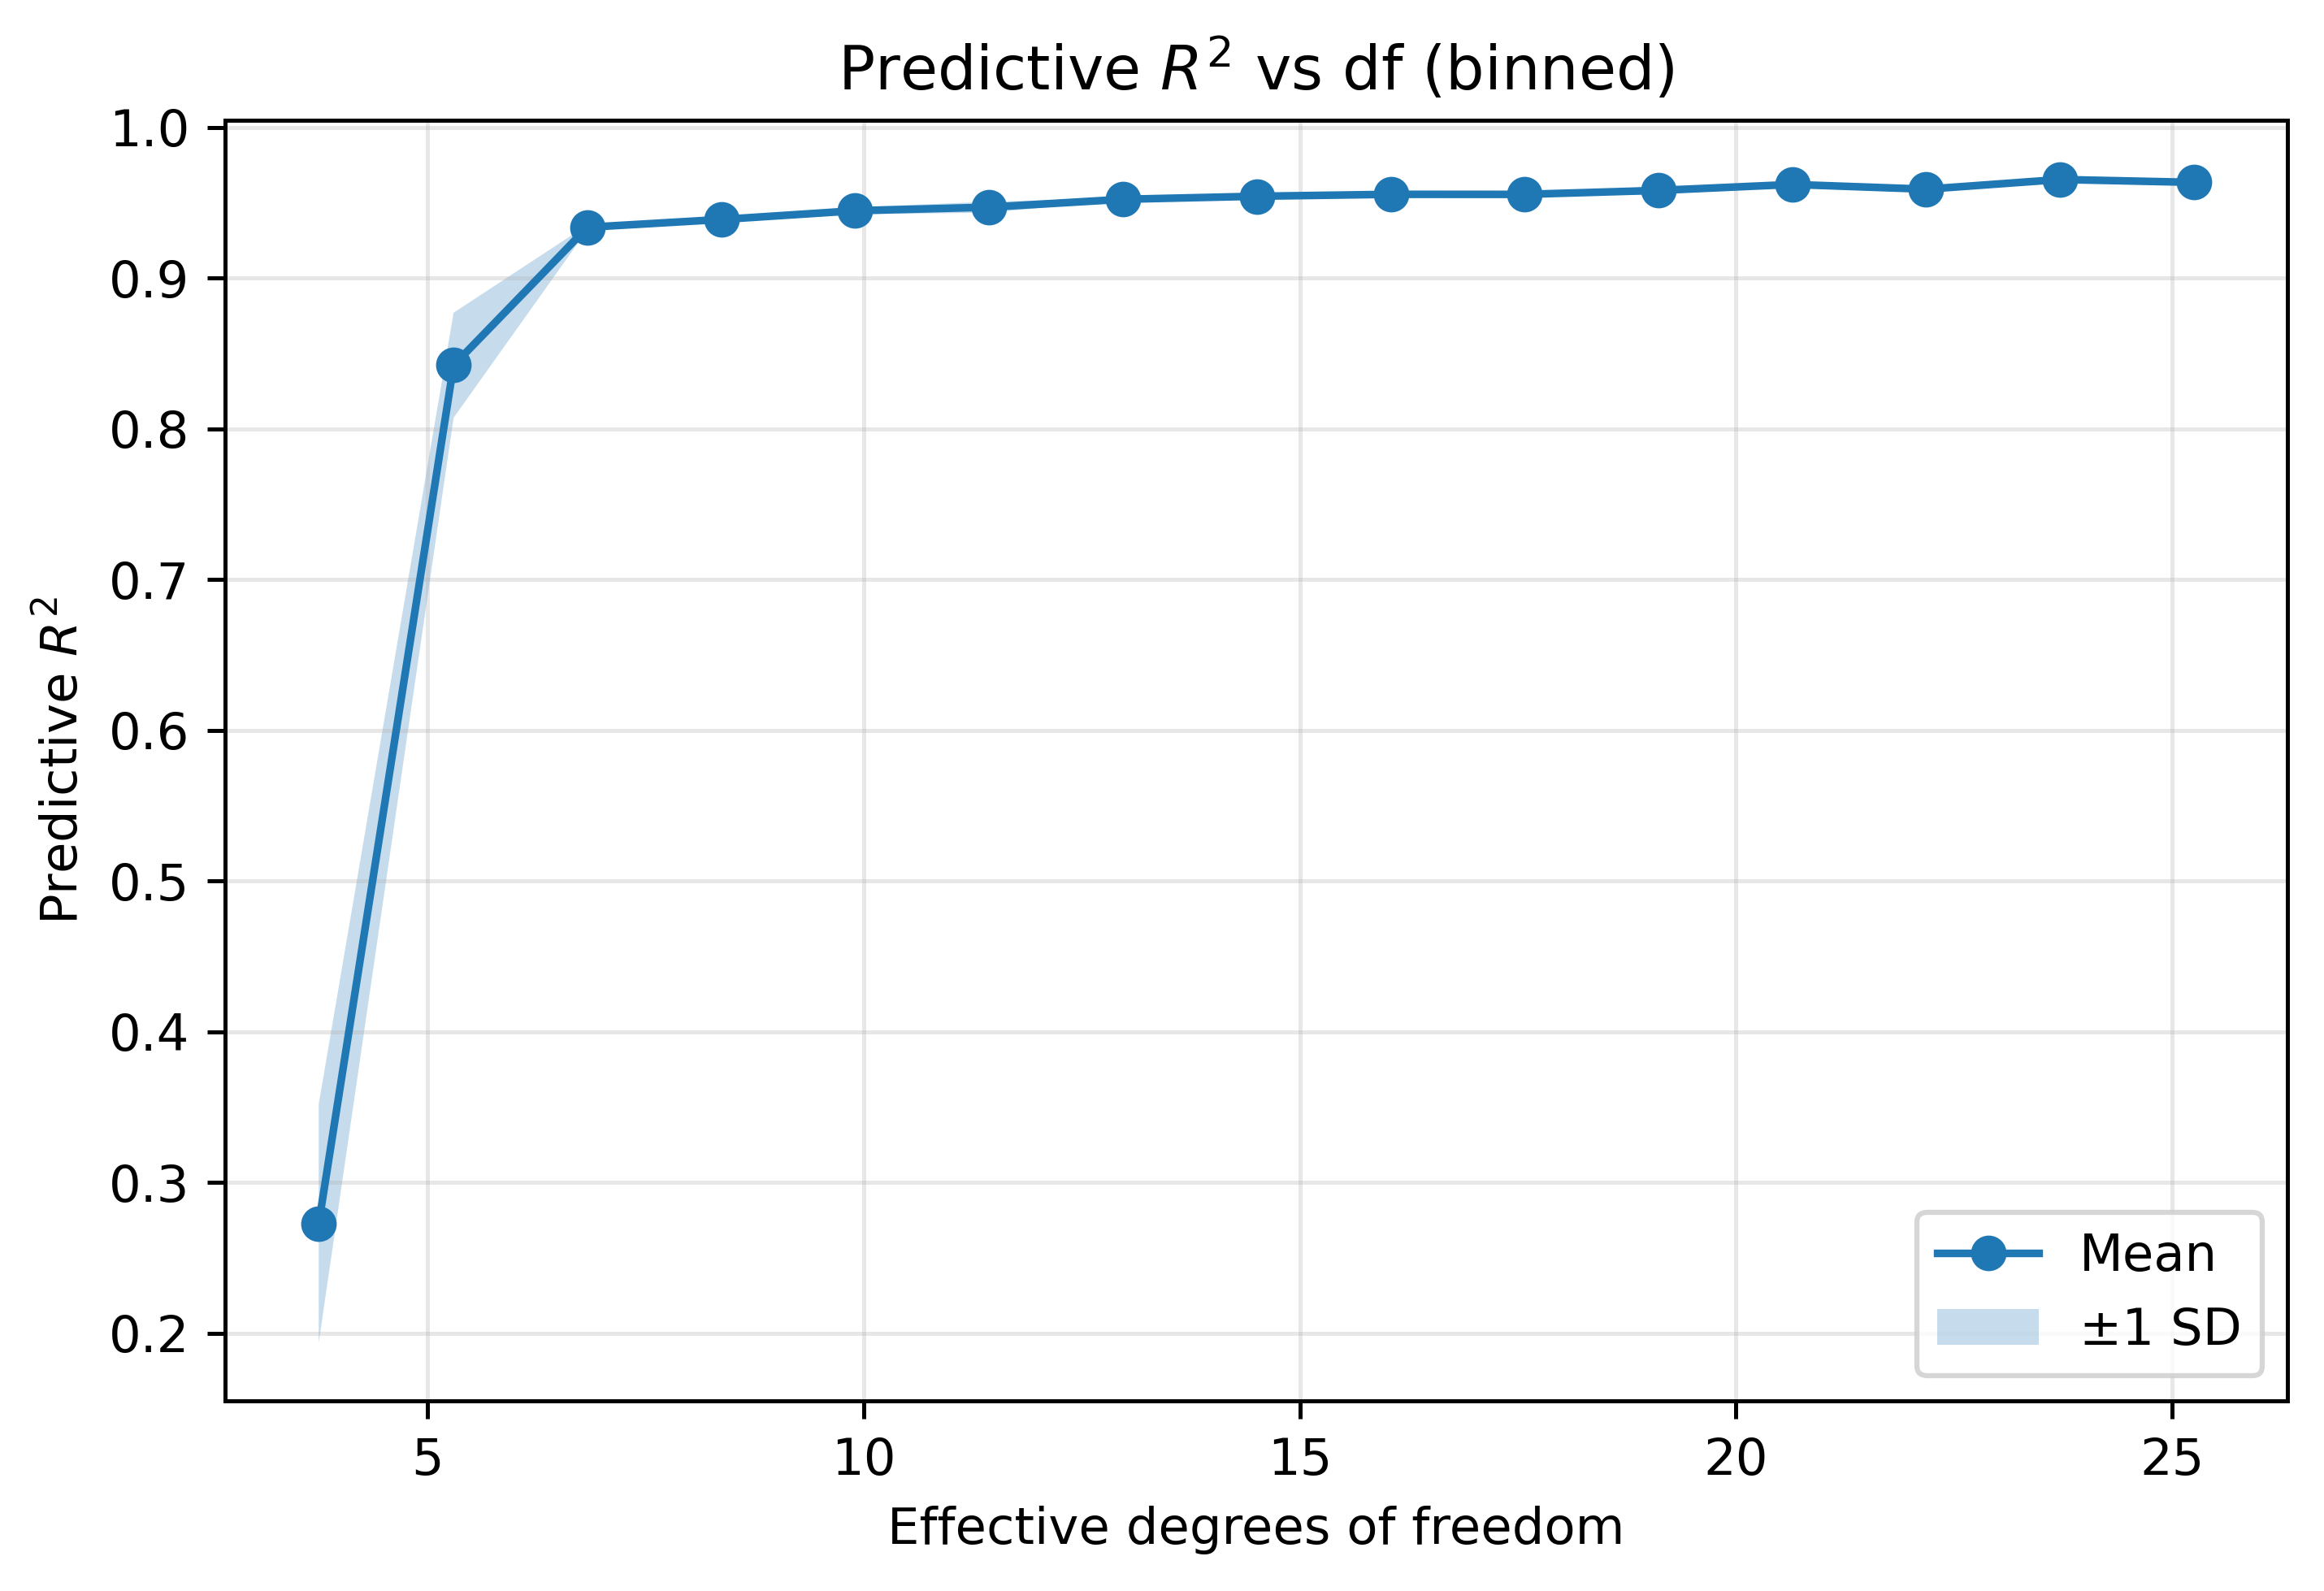

In [8]:
Image(filename="../artifacts/original_data/03_flr/plots/R2_vs_df_binned.png", width=600)

This is an incredibly strong relationship! This provides great evidence that degrees of freedom are what matters for $R_{pred}^{2}$.

This concludes our analysis of different choices for hyperparameters.

## Evaluate repeated CV $R^{2}$

We now repeat a similar experiment as in the end of the notebooks `01_ols.ipynb` and `02_ridge.ipynb`. We run 10-fold CV ridge regression 10 times to get 100 different generalization $R^{2}$ estimates. This means for each of the 100 estimates, we have CV train and test sets. We take each train set and perform a leave-one-out cross-validation (LOOCV) to choose the best penalty parameter $\lambda$, then evaluate the regression with this $\lambda$ on the test set. We report the mean, standard deviation, and boxplot of the 100 resulting $R^{2}$ values. Note that this procedure to choose the best hyperparameter for each training set differs from the 10-fold CV used in the previous analyses. We choose LOOCV for numerical advantages.

OLS CV R^2 mean: 0.9308
OLS CV R^2 standard deviation: 0.0773

Ridge CV R^2 mean: 0.9547
Ridge CV R^2 standard deviation: 0.0431

FLR CV R^2 mean: 0.9574
FLR CV R^2 standard deviation: 0.0222


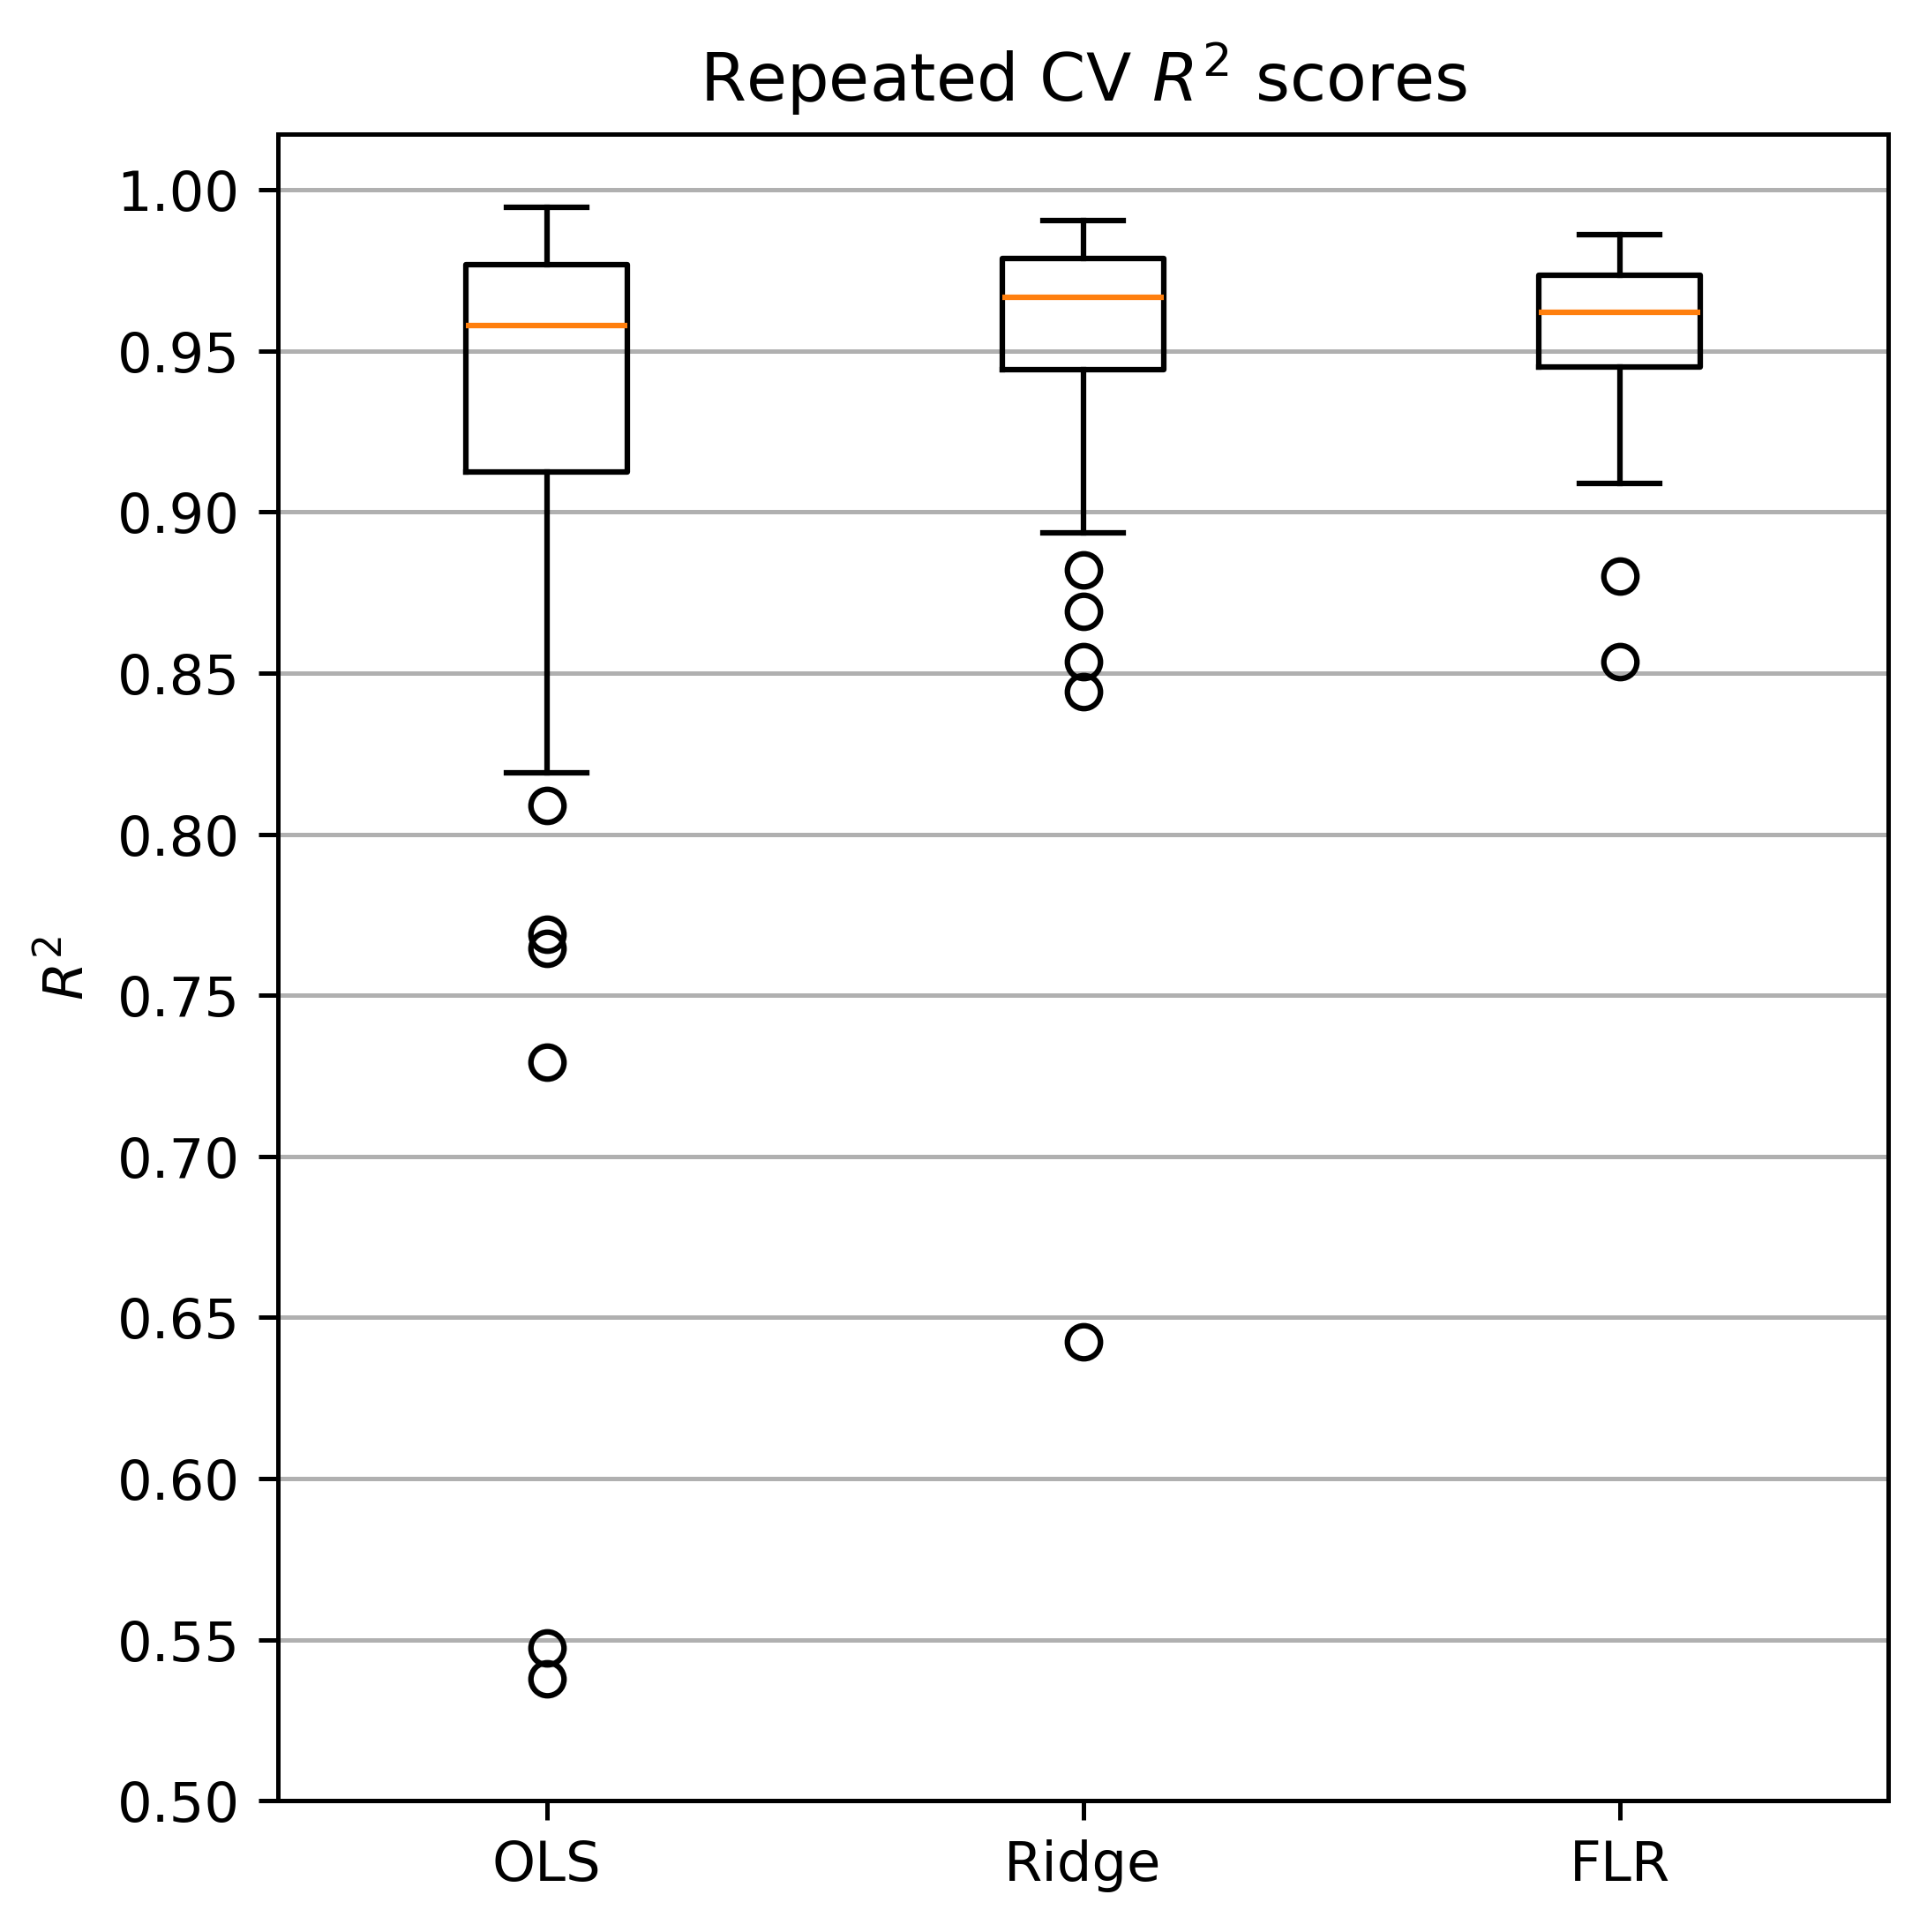

In [9]:
# Load the R^2 scores for OLS, Ridge, and FLR.
with open(str((Path(os.getcwd()).parent / "artifacts" / "original_data" / "01_ols" / "results" / "ols_cv.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    ols_cv_scores = pickle.load(f).r2_scores

with open(str((Path(os.getcwd()).parent / "artifacts" / "original_data" / "02_ridge" / "repeated_cv_results" / "results.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    ridge_cv_scores = pickle.load(f)

with open(str((Path(os.getcwd()).parent / "artifacts" / "original_data" / "03_flr" / "repeated_cv_results" / "results.pkl")), "rb") as f: # We're currently in <repo>/notebooks/01_ols.ipynb, but we need to be in <repo>/data/01_ols.
    flr_cv_scores = pickle.load(f)

print("OLS CV R^2 mean:", round(ols_cv_scores.mean(), 4))
print("OLS CV R^2 standard deviation:", round(ols_cv_scores.std(), 4))
print()
print("Ridge CV R^2 mean:", round(ridge_cv_scores.mean(), 4))
print("Ridge CV R^2 standard deviation:", round(ridge_cv_scores.std(), 4))
print()
print("FLR CV R^2 mean:", round(flr_cv_scores["r2_scores"].mean(), 4))
print("FLR CV R^2 standard deviation:", round(flr_cv_scores["r2_scores"].std(), 4))

Image(filename="../artifacts/original_data/03_flr/plots/comparison.png", width=400)

Ridge and FLR are very similar! Just from this chart, there's not enough evidence to say that one generalizes to test sets better than the other.